## Setup

In [1]:
import os 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [220]:
train = pd.read_csv('cat-in-dat/train.csv')
test = pd.read_csv('cat-in-dat/test.csv')

In [3]:
train.shape

(600000, 25)

In [4]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [178]:
train.isna().sum() #checking missing values

id            0
bin_0     17894
bin_1     18003
bin_2     17930
bin_3     18014
bin_4     18047
nom_0     18252
nom_1     18156
nom_2     18035
nom_3     18121
nom_4     18035
nom_5     17778
nom_6     18131
nom_7     18003
nom_8     17755
nom_9     18073
ord_0     18288
ord_1     18041
ord_2     18075
ord_3     17916
ord_4     17930
ord_5     17713
day       17952
month     17988
target        0
dtype: int64

In [179]:
test.isna().sum()

id           0
bin_0    11901
bin_1    12038
bin_2    11972
bin_3    11951
bin_4    11951
nom_0    12062
nom_1    11947
nom_2    12179
nom_3    12176
nom_4    11993
nom_5    11912
nom_6    12012
nom_7    12003
nom_8    11956
nom_9    12060
ord_0    11893
ord_1    12167
ord_2    12105
ord_3    12053
ord_4    11933
ord_5    12047
day      12025
month    11984
dtype: int64

In [ ]:
#Since there is no order among entities of the nominal variables I will apply sklearn one hot encoding to them.

In [5]:
nom_cols=['nom_0','nom_1','nom_2','nom_3','nom_4','nom_5','nom_6','nom_7','nom_8','nom_9']
ord_cols=['ord_0','ord_1','ord_2','ord_3','ord_4','ord_5']

## Nominal Attributes - Data Exploration

In [ ]:
train['nom_1'].value_counts(normalize=True) #dropna=False can be used here.

In [ ]:
test['nom_1'].value_counts(normalize=True)

In [ ]:
nom_df= train.filter(nom_cols, axis=1); nom_df

In [ ]:
print("Entities of Nominal Variables by Target Variable")
for i in range(5):
    data = train[[f'nom_{i}', 'target']].groupby(f'nom_{i}')['target'].value_counts(normalize=True).unstack()
    display(data)

In [ ]:
for i in nom_df:
    nom_col = nom_df[i].value_counts(normalize=True)
    if nom_col.count() < 10:  
        sns.barplot(nom_col.index, nom_col.values, alpha=0.9) 
        plt.title(i)
        plt.ylabel('Number of Occurrences', fontsize=12)
        plt.xlabel('Entity', fontsize=12)
        plt.show() #displays frequencies of each nominal category with low cardinality

## Handling Missing Values

### Flling with max

In [166]:
final=train.apply(lambda x: x.fillna(x.value_counts().index[0]))

In [167]:
final_test=test.apply(lambda x: x.fillna(x.value_counts().index[0]))

In [29]:
final.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,India,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,Triangle,Hamster,Canada,...,8f3276a6e,3.0,Novice,Freezing,n,P,eN,5.0,9.0,0
3,3,0.0,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,Fl,3.0,3.0,0
4,4,0.0,0.0,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


## Transforming Nominal Attributes

### Mean Coding

In [221]:
for col in train.filter(nom_cols, axis=1):
    means=train.groupby(col).target.mean()
    train[col+'_mean_target']=train.loc[train[col].notnull(), col].map(means)
    test[col+'_mean_target']=test.loc[test[col].notnull(), col].map(means)

In [222]:
final=train.drop(nom_cols, axis=1)
final_test=test.drop(nom_cols, axis=1)

In [195]:
final.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,day,...,nom_3_mean_target,nom_4_mean_target,nom_5_mean_target,nom_6_mean_target,nom_7_mean_target,nom_8_mean_target,nom_9_mean_target,ord_3_mean_target,ord_4_mean_target,ord_5_mean_target
0,0,0.0,0.0,0.0,F,N,3.0,Contributor,Hot,6.0,...,0.219534,0.207375,0.209756,0.161017,0.103301,0.128509,0.164251,0.113524,0.222938,0.143608
1,1,1.0,1.0,0.0,F,Y,3.0,Grandmaster,Warm,7.0,...,NaN,0.179573,0.193767,0.200913,0.129012,0.197291,0.152830,0.135513,0.233747,0.236897
2,2,0.0,1.0,0.0,F,N,3.0,NaN,Freezing,5.0,...,0.159849,0.207375,0.181311,0.163690,0.262747,0.172607,NaN,0.289383,0.201003,0.208738
3,3,NaN,0.0,0.0,F,N,1.0,Novice,Lava Hot,3.0,...,0.178947,0.179573,0.207358,0.203390,0.144197,0.224036,0.268456,0.091502,0.138982,NaN
4,4,0.0,NaN,0.0,T,N,3.0,Grandmaster,Cold,5.0,...,0.202836,NaN,0.152913,0.162055,0.195469,NaN,0.250000,0.182082,0.138982,0.160131


In [12]:
final.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,ord_3,...,nom_0_mean_target,nom_1_mean_target,nom_2_mean_target,nom_3_mean_target,nom_4_mean_target,nom_5_mean_target,nom_6_mean_target,nom_7_mean_target,nom_8_mean_target,nom_9_mean_target
0,0,0.0,0.0,0.0,F,N,3.0,Contributor,Hot,c,...,0.183186,0.225464,0.169845,0.219534,0.207375,0.209756,0.161017,0.103301,0.128509,0.164251
1,1,1.0,1.0,0.0,F,Y,3.0,Grandmaster,Warm,e,...,0.183186,0.130201,0.201104,0.165594,0.179902,0.193767,0.200913,0.129012,0.197291,0.152830
2,2,0.0,1.0,0.0,F,N,3.0,Novice,Freezing,n,...,0.183186,0.159894,0.169845,0.159849,0.207375,0.181311,0.163690,0.262747,0.172607,0.188486
3,3,0.0,0.0,0.0,F,N,1.0,Novice,Lava Hot,a,...,0.183186,0.179694,0.169845,0.178947,0.179902,0.207358,0.203390,0.144197,0.224036,0.268456
4,4,0.0,0.0,0.0,T,N,3.0,Grandmaster,Cold,h,...,0.183186,0.159894,0.169845,0.202836,0.179902,0.152913,0.162055,0.195469,0.184636,0.250000


## Get Dummies - Cancelled

In [6]:
dummies=pd.get_dummies(data=nom_df, columns=nom_cols, drop_first=True)

In [ ]:
dummies_test=pd.get_dummies(data=nom_df_test, columns=nom_cols, drop_first=True); dummies_test

In [7]:
final=pd.concat([filled_train, dummies], axis=1).drop(nom_cols, axis=1) 

In [ ]:
final_test=pd.concat([filled_test, dummies_test], axis=1).drop(nom_cols, axis=1) 

In [8]:
final.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,...,nom_2_Lion,nom_2_Snake,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Oboe,nom_4_Piano,nom_4_Theremin
0,0,0.0,0.0,0.0,F,N,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,...,0,0,0,0,0,0,1,0,0,0
1,1,1.0,1.0,0.0,F,Y,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,...,0,0,0,0,0,1,0,0,0,1
2,2,0.0,1.0,0.0,F,N,b574c9841,708248125,5ddc9a726,745b909d1,...,0,0,0,0,0,0,0,0,0,0
3,3,0.0,0.0,0.0,F,N,673bdf1f6,23edb8da3,3a33ef960,bdaa56dd1,...,0,0,0,0,1,0,0,0,0,1
4,4,0.0,0.0,0.0,T,N,777d1ac2c,3a7975e46,bc9cc2a94,7d7c02c57,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
final_test.head()

### Label Encoding - Cancelled

In [ ]:
#day=final['day'].value_counts().to_dict()
#month=final['month'].value_counts().to_dict()
freq5=final['nom_5'].value_counts().to_dict()
freq6=final['nom_6'].value_counts().to_dict()
freq7=final['nom_7'].value_counts().to_dict()
freq8=final['nom_8'].value_counts().to_dict()
freq9=final['nom_9'].value_counts().to_dict()

In [148]:
#final['day']=final['day'].map(day)
#final['month']=final['month'].map(month)
final['nom_5']=final['nom_5'].map(freq5)
final['nom_6']=final['nom_6'].map(freq6)
final['nom_7']=final['nom_7'].map(freq7)
final['nom_8']=final['nom_8'].map(freq8)
final['nom_9']=final['nom_9'].map(freq9)

In [149]:
final.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,...,ord_4,ord_5,day,month,target,nom_0_mean_target,nom_1_mean_target,nom_2_mean_target,nom_3_mean_target,nom_4_mean_target
0,0,0.0,0.0,0.0,F,N,410,118,1878,1603,...,U,Pw,6.0,3.0,0,0.183186,0.225464,0.169845,0.219534,0.207375
1,1,1.0,1.0,0.0,F,Y,738,438,4767,2879,...,X,pE,7.0,7.0,0,0.183186,0.130201,0.201104,0.165594,0.179902
2,2,0.0,1.0,0.0,F,N,717,672,3334,4293,...,P,eN,5.0,9.0,0,0.183186,0.159894,0.169845,0.159849,0.207375
3,3,0.0,0.0,0.0,F,N,598,590,3093,2205,...,C,Fl,3.0,3.0,0,0.183186,0.179694,0.169845,0.178947,0.179902
4,4,0.0,0.0,0.0,T,N,824,253,4502,22807,...,C,OZ,5.0,12.0,0,0.183186,0.159894,0.169845,0.202836,0.179902


## Transforming Ordinal Attributes

### Mean Encoding

In [223]:
for col in final.filter(['ord_3','ord_4','ord_5'], axis=1):
    means=final.groupby(col).target.mean()
    final[col+'_mean_target']=final.loc[final[col].notnull(), col].map(means)
    final_test[col+'_mean_target']=final_test.loc[final_test[col].notnull(), col].map(means)

In [224]:
final.drop(columns=['ord_3','ord_4','ord_5'], axis=1, inplace=True)
final_test.drop(columns=['ord_3','ord_4','ord_5'], axis=1, inplace=True)

In [194]:
final.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,day,...,nom_3_mean_target,nom_4_mean_target,nom_5_mean_target,nom_6_mean_target,nom_7_mean_target,nom_8_mean_target,nom_9_mean_target,ord_3_mean_target,ord_4_mean_target,ord_5_mean_target
0,0,0.0,0.0,0.0,F,N,3.0,Contributor,Hot,6.0,...,0.219534,0.207375,0.209756,0.161017,0.103301,0.128509,0.164251,0.113524,0.222938,0.143608
1,1,1.0,1.0,0.0,F,Y,3.0,Grandmaster,Warm,7.0,...,NaN,0.179573,0.193767,0.200913,0.129012,0.197291,0.152830,0.135513,0.233747,0.236897
2,2,0.0,1.0,0.0,F,N,3.0,NaN,Freezing,5.0,...,0.159849,0.207375,0.181311,0.163690,0.262747,0.172607,NaN,0.289383,0.201003,0.208738
3,3,NaN,0.0,0.0,F,N,1.0,Novice,Lava Hot,3.0,...,0.178947,0.179573,0.207358,0.203390,0.144197,0.224036,0.268456,0.091502,0.138982,NaN
4,4,0.0,NaN,0.0,T,N,3.0,Grandmaster,Cold,5.0,...,0.202836,NaN,0.152913,0.162055,0.195469,NaN,0.250000,0.182082,0.138982,0.160131


### Label Encoding - Cancelled

In [559]:
ord_5=dict(zip(final['ord_5'].value_counts().sort_index().keys(),
         range(1, len(final['ord_5'].value_counts())+1)))
ord_4=dict(zip(final['ord_4'].value_counts().sort_index().keys(),
         range(1, len(final['ord_4'].value_counts())+1)))
ord_3=dict(zip(final['ord_3'].value_counts().sort_index().keys(),
         range(1, len(final['ord_3'].value_counts())+1)))

In [560]:
final['ord_5']=final['ord_5'].map(ord_5)
final['ord_4']=final['ord_4'].map(ord_4)
final['ord_3']=final['ord_3'].map(ord_3)

In [561]:
final_test['ord_5']=final_test['ord_5'].map(ord_5)
final_test['ord_4']=final_test['ord_4'].map(ord_4)
final_test['ord_3']=final_test['ord_3'].map(ord_3)

In [188]:
final['ord_5'].value_counts(normalize=True).sort_values(ascending=False)

22     0.047125
13     0.015878
72     0.014423
63     0.009413
146    0.009327
         ...   
177    0.000315
114    0.000207
175    0.000200
105    0.000152
94     0.000145
Name: ord_5, Length: 190, dtype: float64

In [330]:
final_test['ord_3'].value_counts(normalize=True).sort_values(ascending=False)

14    0.148962
1     0.109063
13    0.095930
3     0.094720
8     0.092435
15    0.076210
2     0.073640
5     0.064070
11    0.064000
9     0.058632
4     0.051380
6     0.049427
7     0.010507
10    0.006130
12    0.004893
Name: ord_3, dtype: float64

In [562]:
final.filter(ord_cols, axis=1)

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
0,3.0,Contributor,Hot,3,21,57
1,3.0,Grandmaster,Warm,5,24,151
2,3.0,Novice,Freezing,14,16,106
3,1.0,Novice,Lava Hot,1,3,22
4,3.0,Grandmaster,Cold,8,3,51
...,...,...,...,...,...,...
599995,3.0,Novice,Freezing,1,18,23
599996,2.0,Novice,Boiling Hot,14,14,164
599997,2.0,Contributor,Freezing,14,8,43
599998,1.0,Master,Warm,13,24,19


In [331]:
final_test.filter(ord_cols, axis=1)

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
0,3.0,Novice,Boiling Hot,6,21,147
1,1.0,Novice,Cold,14,14,22
2,1.0,Expert,Warm,9,14,13
3,1.0,Expert,Hot,13,2,1
4,1.0,Contributor,Lava Hot,15,10,15
...,...,...,...,...,...,...
399995,2.0,Expert,Warm,14,18,104
399996,1.0,Contributor,Freezing,14,24,80
399997,1.0,Grandmaster,Boiling Hot,13,16,74
399998,3.0,Novice,Lava Hot,8,12,12


### Ordinal Encoding

This encoding is similar to label encoding however, label encoding would not consider whether variable is ordinal or not. Since it is important the ordinality for the variables ord_1 and ord_2, I will apply ordinal encoding.

In [40]:
final['ord_1'].value_counts(normalize=True)

Novice         0.297730
Expert         0.232795
Contributor    0.183035
Grandmaster    0.159777
Master         0.126663
Name: ord_1, dtype: float64

In [41]:
final_test['ord_1'].value_counts(normalize=True)

Novice         0.297490
Expert         0.232157
Contributor    0.182672
Grandmaster    0.159965
Master         0.127715
Name: ord_1, dtype: float64

In [42]:
final['ord_2'].value_counts(normalize=True)

Freezing       0.268002
Warm           0.207065
Cold           0.163037
Boiling Hot    0.141317
Hot            0.112513
Lava Hot       0.108067
Name: ord_2, dtype: float64

In [43]:
final_test['ord_2'].value_counts(normalize=True)

Freezing       0.268480
Warm           0.207350
Cold           0.162605
Boiling Hot    0.141560
Hot            0.111272
Lava Hot       0.108732
Name: ord_2, dtype: float64

In [225]:
ord_1_dict ={'Novice': 1,
            'Contributor': 2,
            'Expert': 3,
            'Master': 4,
            'Grandmaster': 5}
ord_2_dict = {'Freezing': 1,
            'Cold': 2,
            'Warm': 3,
            'Hot': 4,
            'Boiling Hot': 5,
            'Lava Hot': 6}

In [226]:
final['ord_1']=final.ord_1.map(ord_1_dict)
final['ord_2']=final.ord_2.map(ord_2_dict)

In [227]:
final_test['ord_1']=final_test.ord_1.map(ord_1_dict)
final_test['ord_2']=final_test.ord_2.map(ord_2_dict)

In [228]:
final.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,day,...,nom_3_mean_target,nom_4_mean_target,nom_5_mean_target,nom_6_mean_target,nom_7_mean_target,nom_8_mean_target,nom_9_mean_target,ord_3_mean_target,ord_4_mean_target,ord_5_mean_target
0,0,0.0,0.0,0.0,F,N,3.0,2.0,4.0,6.0,...,0.219534,0.207375,0.209756,0.161017,0.103301,0.128509,0.164251,0.113524,0.222938,0.143608
1,1,1.0,1.0,0.0,F,Y,3.0,5.0,3.0,7.0,...,NaN,0.179573,0.193767,0.200913,0.129012,0.197291,0.152830,0.135513,0.233747,0.236897
2,2,0.0,1.0,0.0,F,N,3.0,NaN,1.0,5.0,...,0.159849,0.207375,0.181311,0.163690,0.262747,0.172607,NaN,0.289383,0.201003,0.208738
3,3,NaN,0.0,0.0,F,N,1.0,1.0,6.0,3.0,...,0.178947,0.179573,0.207358,0.203390,0.144197,0.224036,0.268456,0.091502,0.138982,NaN
4,4,0.0,NaN,0.0,T,N,3.0,5.0,2.0,5.0,...,0.202836,NaN,0.152913,0.162055,0.195469,NaN,0.250000,0.182082,0.138982,0.160131


In [48]:
final_test.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,day,...,nom_3_mean_target,nom_4_mean_target,nom_5_mean_target,nom_6_mean_target,nom_7_mean_target,nom_8_mean_target,nom_9_mean_target,ord_3_mean_target,ord_4_mean_target,ord_5_mean_target
0,600000,0.0,0.0,0.0,F,Y,3.0,1,5,3.0,...,0.178947,0.140327,0.157827,0.151261,0.125761,0.182075,0.146751,0.151036,0.222938,0.235641
1,600001,0.0,0.0,0.0,F,Y,1.0,1,2,2.0,...,0.219534,0.207375,0.155556,0.213166,0.175406,0.234127,0.191781,0.268994,0.187694,0.163537
2,600002,0.0,0.0,0.0,F,Y,1.0,3,3,2.0,...,0.219534,0.179902,0.210823,0.174699,0.251001,0.144341,0.162252,0.196071,0.187694,0.125748
3,600003,1.0,0.0,0.0,F,N,1.0,3,4,1.0,...,0.202836,0.207375,0.241458,0.204947,0.184991,0.169082,0.173469,0.265988,0.135848,0.108688
4,600004,0.0,0.0,1.0,F,Y,1.0,2,6,3.0,...,0.178947,0.179902,0.194495,0.153646,0.250290,0.121985,0.154574,0.309608,0.175385,0.119081


## Transforming Binary Attributes

In [229]:
from sklearn.preprocessing import LabelEncoder

In [201]:
final_test.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,day,...,nom_3_mean_target,nom_4_mean_target,nom_5_mean_target,nom_6_mean_target,nom_7_mean_target,nom_8_mean_target,nom_9_mean_target,ord_3_mean_target,ord_4_mean_target,ord_5_mean_target
0,600000,0.0,0.0,0.0,F,Y,3.0,1.0,5.0,3.0,...,0.178947,0.140327,0.157827,0.151261,0.125761,0.182075,0.146751,0.151036,0.222938,0.235641
1,600001,0.0,0.0,0.0,F,Y,1.0,1.0,2.0,2.0,...,0.219534,0.207375,0.155556,0.213166,0.175406,0.234127,0.191781,0.289383,0.187103,NaN
2,600002,0.0,0.0,0.0,F,Y,1.0,3.0,3.0,2.0,...,0.219534,0.179573,0.210823,0.174699,0.251001,0.144341,0.162252,0.196071,0.187103,0.125748
3,600003,1.0,0.0,0.0,F,N,1.0,3.0,4.0,1.0,...,0.202836,0.207375,0.241458,0.204947,0.184991,0.169082,0.173469,0.265988,0.135848,0.108688
4,600004,0.0,0.0,1.0,F,Y,1.0,2.0,6.0,3.0,...,0.178947,0.179573,0.194495,0.153646,0.250290,0.121985,0.154574,0.309608,0.175385,0.119081


In [108]:
final['bin_3'].value_counts(normalize=True)

F    0.640377
T    0.359623
Name: bin_3, dtype: float64

In [109]:
final['bin_4'].value_counts(normalize=True)

N    0.550652
Y    0.449348
Name: bin_4, dtype: float64

In [230]:
final.bin_3.replace({'F':0, 'T':1}, inplace=True)
final.bin_4.replace({'N':0, 'Y':1}, inplace=True)

In [231]:
final_test.bin_3.replace({'F':0, 'T':1}, inplace=True)
final_test.bin_4.replace({'N':0, 'Y':1}, inplace=True)

In [232]:
final_test.shape

(400000, 24)

In [233]:
final.shape

(600000, 25)

In [234]:
final.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,day,...,nom_3_mean_target,nom_4_mean_target,nom_5_mean_target,nom_6_mean_target,nom_7_mean_target,nom_8_mean_target,nom_9_mean_target,ord_3_mean_target,ord_4_mean_target,ord_5_mean_target
0,0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,4.0,6.0,...,0.219534,0.207375,0.209756,0.161017,0.103301,0.128509,0.164251,0.113524,0.222938,0.143608
1,1,1.0,1.0,0.0,0.0,1.0,3.0,5.0,3.0,7.0,...,NaN,0.179573,0.193767,0.200913,0.129012,0.197291,0.152830,0.135513,0.233747,0.236897
2,2,0.0,1.0,0.0,0.0,0.0,3.0,NaN,1.0,5.0,...,0.159849,0.207375,0.181311,0.163690,0.262747,0.172607,NaN,0.289383,0.201003,0.208738
3,3,NaN,0.0,0.0,0.0,0.0,1.0,1.0,6.0,3.0,...,0.178947,0.179573,0.207358,0.203390,0.144197,0.224036,0.268456,0.091502,0.138982,NaN
4,4,0.0,NaN,0.0,1.0,0.0,3.0,5.0,2.0,5.0,...,0.202836,NaN,0.152913,0.162055,0.195469,NaN,0.250000,0.182082,0.138982,0.160131


In [129]:
final_test.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8,nom_9,ord_1,ord_2,day,month,ord_0_mean_target,ord_3_mean_target,ord_4_mean_target,ord_5_mean_target
0,600000,0.0,0.0,0.0,0,1,Blue,Polygon,Axolotl,Finland,...,ca9ad1d4b,fced9e114,1,5,3.0,9.0,0.239775,0.151036,0.222938,0.235641
1,600001,0.0,0.0,0.0,0,1,Red,Circle,Lion,Russia,...,060a21580,7ca8775da,1,2,2.0,8.0,0.145403,0.268994,0.187694,0.163537
2,600002,0.0,0.0,0.0,0,1,Blue,Circle,Axolotl,Russia,...,165e81a00,5940334c9,3,3,2.0,6.0,0.145403,0.196071,0.187694,0.125748
3,600003,1.0,0.0,0.0,0,0,Red,Polygon,Axolotl,Costa Rica,...,77d41330d,6fbdeefc8,3,4,1.0,6.0,0.145403,0.265988,0.135848,0.108688
4,600004,0.0,0.0,1.0,0,1,Red,Circle,Hamster,Finland,...,2218d9dfe,2a27c8fde,2,6,3.0,3.0,0.145403,0.309608,0.175385,0.119081


### Transforming Datetime

In [235]:
for col in final.filter(items=['day','month']):
    means=final.groupby(col).target.mean()
    final[col+'_mean_target']=final.loc[final[col].notnull(), col].map(means)
    final_test[col+'_mean_target']=final_test.loc[final_test[col].notnull(),col].map(means)

In [236]:
final_test.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,day,...,nom_5_mean_target,nom_6_mean_target,nom_7_mean_target,nom_8_mean_target,nom_9_mean_target,ord_3_mean_target,ord_4_mean_target,ord_5_mean_target,day_mean_target,month_mean_target
0,600000,0.0,0.0,0.0,0.0,1.0,3.0,1.0,5.0,3.0,...,0.157827,0.151261,0.125761,0.182075,0.146751,0.151036,0.222938,0.235641,0.164080,0.211688
1,600001,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,...,0.155556,0.213166,0.175406,0.234127,0.191781,0.289383,0.187103,NaN,0.199160,0.190094
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,2.0,...,0.210823,0.174699,0.251001,0.144341,0.162252,0.196071,0.187103,0.125748,0.199160,0.229951
3,600003,1.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,1.0,...,0.241458,0.204947,0.184991,0.169082,0.173469,0.265988,0.135848,0.108688,0.213682,0.229951
4,600004,0.0,0.0,1.0,0.0,1.0,1.0,2.0,6.0,3.0,...,0.194495,0.153646,0.250290,0.121985,0.154574,0.309608,0.175385,0.119081,0.164080,0.146451


## Missing Values

In [256]:
final = final.apply(lambda x: x.fillna(method='backfill'))

In [257]:
final_test = final_test.apply(lambda x: x.fillna(method='backfill'))

In [258]:
final.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,day,...,nom_5_mean_target,nom_6_mean_target,nom_7_mean_target,nom_8_mean_target,nom_9_mean_target,ord_3_mean_target,ord_4_mean_target,ord_5_mean_target,day_mean_target,month_mean_target
0,0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,4.0,6.0,...,0.209756,0.161017,0.103301,0.128509,0.164251,0.113524,0.222938,0.143608,0.199832,0.146451
1,1,1.0,1.0,0.0,0.0,1.0,3.0,5.0,3.0,7.0,...,0.193767,0.200913,0.129012,0.197291,0.152830,0.135513,0.233747,0.236897,0.212460,0.209293
2,2,0.0,1.0,0.0,0.0,0.0,3.0,1.0,1.0,5.0,...,0.181311,0.163690,0.262747,0.172607,0.268456,0.289383,0.201003,0.208738,0.163537,0.211688
3,3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,3.0,...,0.207358,0.203390,0.144197,0.224036,0.268456,0.091502,0.138982,0.160131,0.164080,0.146451
4,4,0.0,0.0,0.0,1.0,0.0,3.0,5.0,2.0,5.0,...,0.152913,0.162055,0.195469,0.224250,0.250000,0.182082,0.138982,0.160131,0.163537,0.225841


## Feature Selection

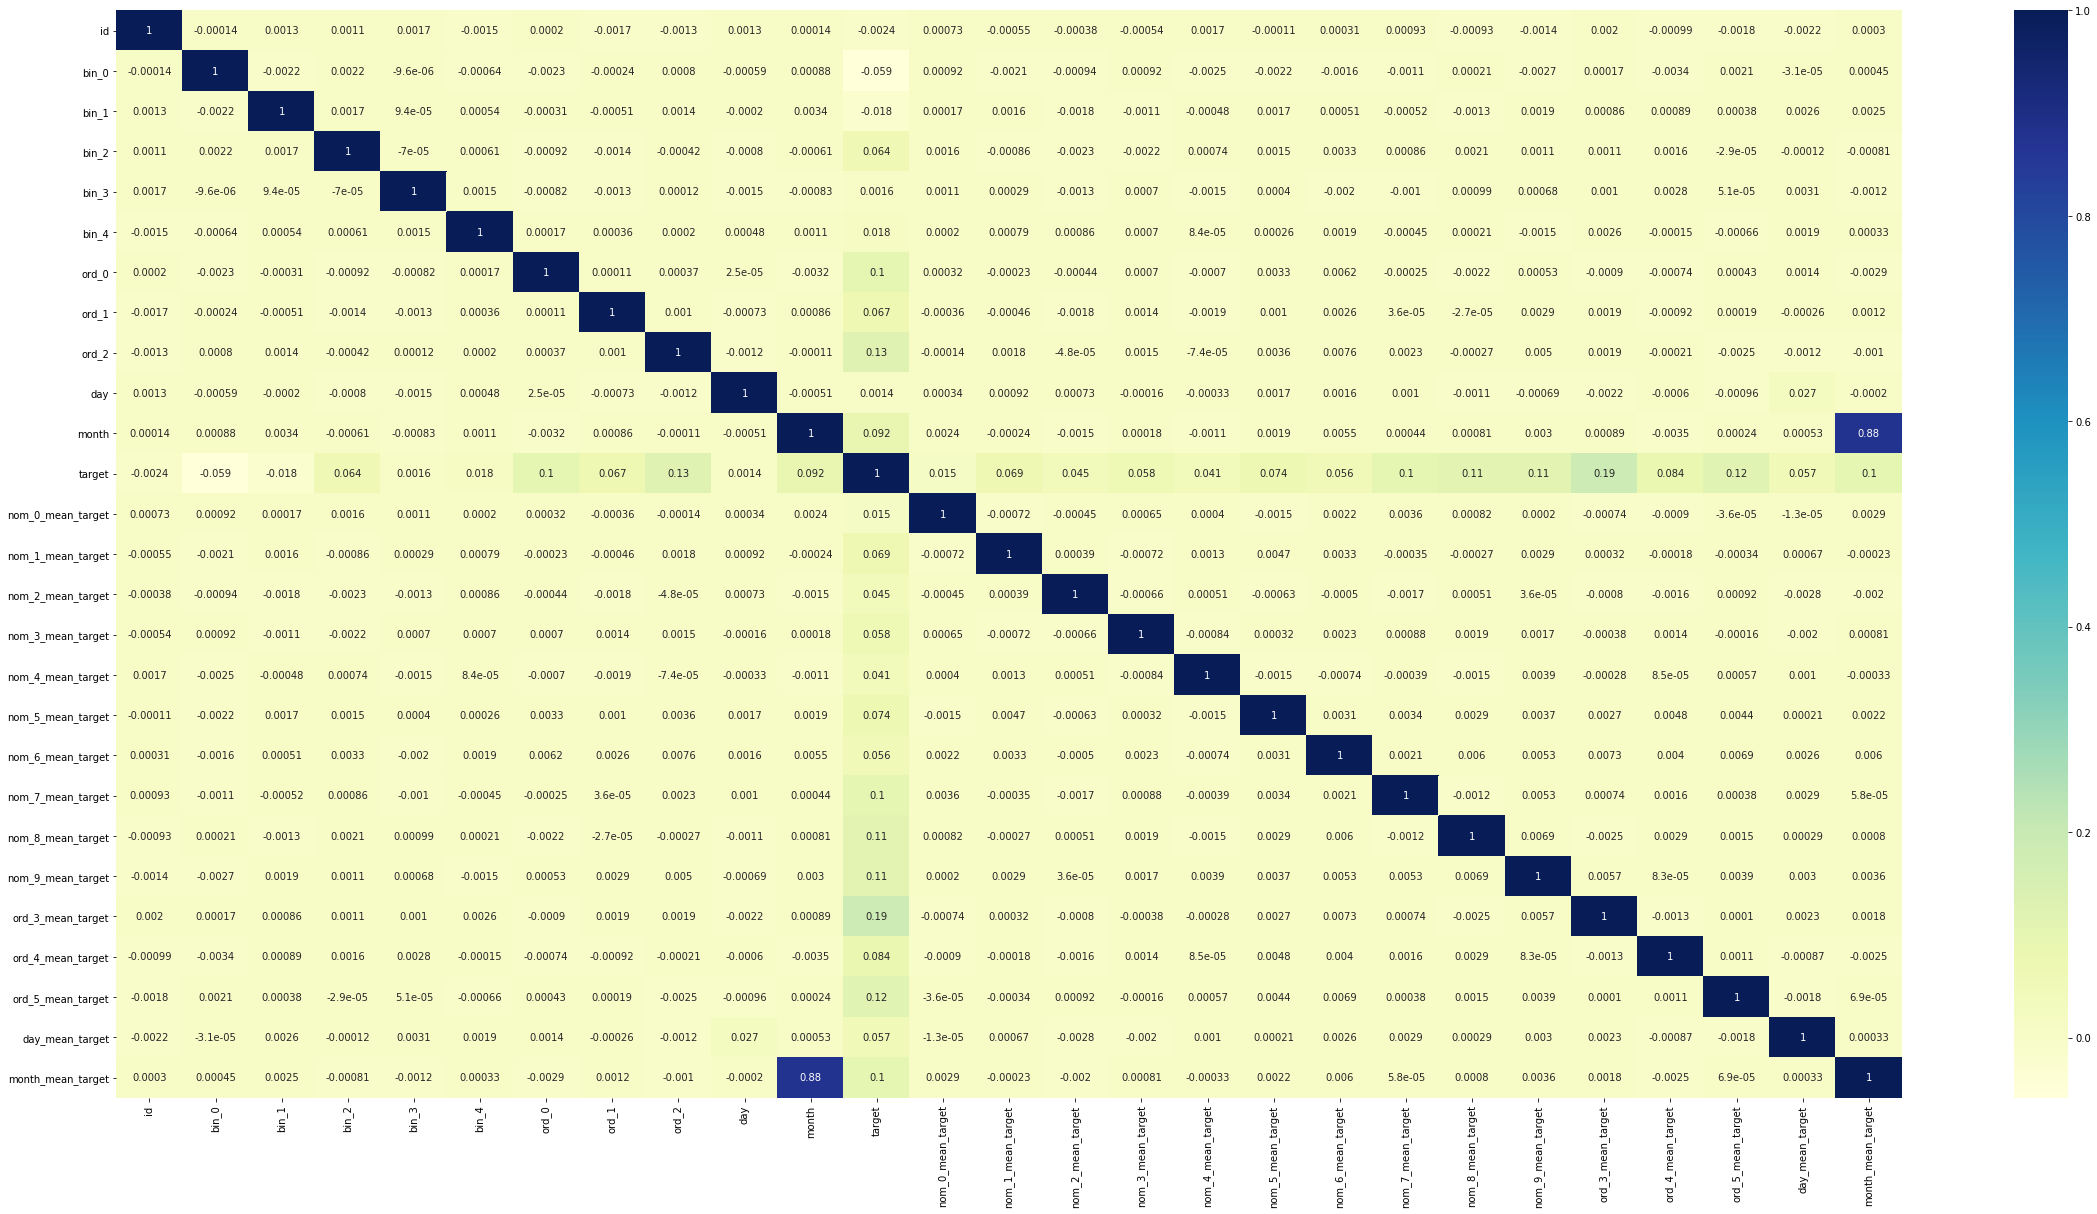

In [259]:
#Using Pearson Correlation
plt.figure(figsize=(40,20))
cor = final.corr()
sns.heatmap(cor, annot=True, cmap="YlGnBu")
plt.show()

In [260]:
#Correlation with output variable
cor_target = abs(cor["target"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0].sort_values(ascending=False)
relevant_features

target               1.000000
ord_3_mean_target    0.188627
ord_2                0.126619
ord_5_mean_target    0.120603
nom_9_mean_target    0.110709
nom_8_mean_target    0.109311
month_mean_target    0.104913
nom_7_mean_target    0.104076
ord_0                0.103484
month                0.092055
ord_4_mean_target    0.084311
nom_5_mean_target    0.073695
nom_1_mean_target    0.068668
ord_1                0.066753
bin_2                0.064189
bin_0                0.058505
nom_3_mean_target    0.058256
day_mean_target      0.056770
nom_6_mean_target    0.055586
nom_2_mean_target    0.044863
nom_4_mean_target    0.041017
bin_4                0.018406
bin_1                0.017836
nom_0_mean_target    0.015327
id                   0.002376
bin_3                0.001585
day                  0.001418
Name: target, dtype: float64

In [261]:
relevant_features = relevant_features.drop(['target','month','day','id'])
#relevant_features = relevant_features.drop(['target','nom_1_Triangle','nom_3_India','nom_1_Polygon','nom_3_Costa Rica','nom_4_Theremin','nom_2_Lion','nom_1_Star'])

The independent variables must be uncorrelated to each other.

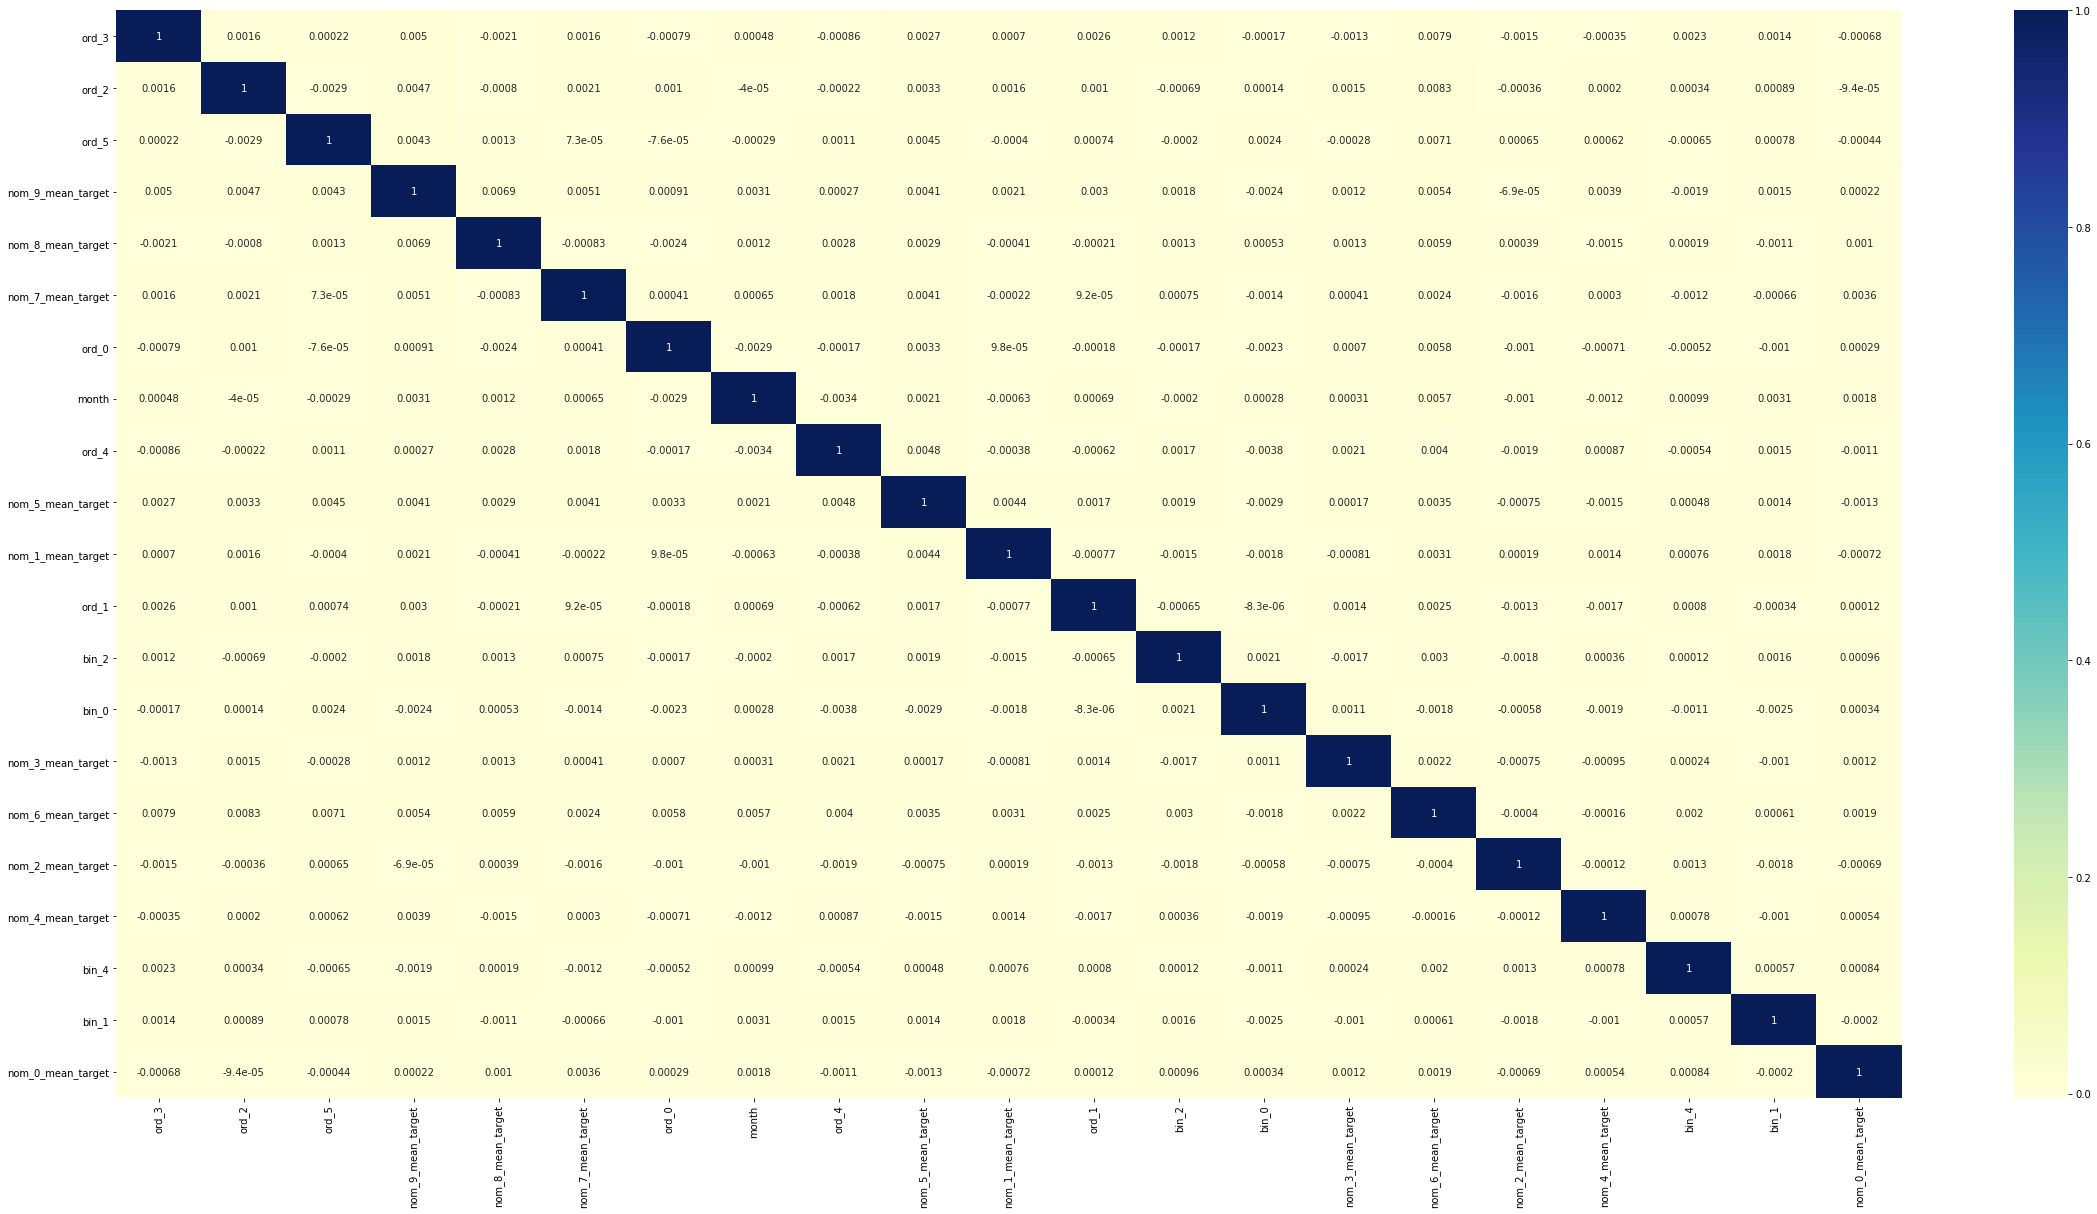

In [414]:
plt.figure(figsize=(40,20))
corr_subset=final[relevant_features.index].corr()
sns.heatmap(corr_subset, annot=True,cmap="YlGnBu")

From the heatmap, it can be seen that the variables nom_1_Triangle and nom_1_Trapezoid are highly correlated to each other (-0.33). There is correlation between nom_3_Russia and nom_3_India as well (-0.33). Therefore, I will keep only one variable and drop the other. I will keep nom_1_Trapezoid and nom_3_Russia since the correlation between the target is higher than the other variables.

## Creating Model

In [262]:
relevant_features.index

Index(['ord_3_mean_target', 'ord_2', 'ord_5_mean_target', 'nom_9_mean_target',
       'nom_8_mean_target', 'month_mean_target', 'nom_7_mean_target', 'ord_0',
       'ord_4_mean_target', 'nom_5_mean_target', 'nom_1_mean_target', 'ord_1',
       'bin_2', 'bin_0', 'nom_3_mean_target', 'day_mean_target',
       'nom_6_mean_target', 'nom_2_mean_target', 'nom_4_mean_target', 'bin_4',
       'bin_1', 'nom_0_mean_target', 'bin_3'],
      dtype='object')

In [263]:
X = final[relevant_features.index]
y = final['target']

In [264]:
X_test = final_test[relevant_features.index]

In [87]:
y

In [467]:
X_test.isna().sum()

ord_3                0
ord_2                0
ord_5                0
nom_9_mean_target    0
nom_8_mean_target    0
nom_7_mean_target    0
ord_0                0
month                0
ord_4                0
nom_5_mean_target    0
nom_1_mean_target    0
ord_1                0
bin_2                0
bin_0                0
nom_3_mean_target    0
nom_6_mean_target    1
nom_2_mean_target    0
nom_4_mean_target    0
dtype: int64

In [ ]:
y.shape

In [ ]:
X.columns

In [255]:
X_test.tail(20)

,ord_3_mean_target,ord_2,ord_5_mean_target,nom_9_mean_target,nom_8_mean_target,month_mean_target,nom_7_mean_target,ord_0,ord_4_mean_target,nom_5_mean_target,...,bin_0,nom_3_mean_target,day_mean_target,nom_6_mean_target,nom_2_mean_target,nom_4_mean_target,bin_4,bin_1,nom_0_mean_target,bin_3
399980,0.113524,3.0,0.243563,0.086124,0.276177,0.229951,0.217864,2.0,0.145221,0.206969,...,0.0,0.202836,0.213682,0.214286,0.168014,0.179573,0.0,0.0,0.179806,1.0
399981,0.228524,5.0,0.230726,0.133333,0.248832,0.146451,0.214551,3.0,0.233747,0.216667,...,0.0,0.178947,0.213682,0.185745,0.181884,0.179573,0.0,0.0,0.183067,0.0
399982,0.265988,1.0,0.204046,0.165877,0.208852,0.229951,0.184953,3.0,0.201003,0.143312,...,0.0,0.163366,0.164080,0.148402,0.168014,0.179573,1.0,1.0,0.195763,0.0
399983,0.135513,6.0,0.193097,0.210191,0.193069,0.121793,0.132466,1.0,0.201003,0.220065,...,0.0,0.178947,NaN,0.182692,0.201104,0.140327,0.0,0.0,0.195763,1.0
399984,0.309608,6.0,0.133509,0.215190,0.197581,0.146451,0.198840,3.0,0.207384,0.204918,...,0.0,0.219534,0.164080,0.178761,0.168014,0.179573,0.0,0.0,0.179806,1.0
399985,0.228524,3.0,NaN,0.168627,0.172607,0.225841,0.195469,2.0,0.219897,0.149194,...,1.0,NaN,0.199832,0.170370,0.209834,0.179573,0.0,1.0,0.195763,0.0
399986,0.309608,2.0,0.210351,0.262136,0.178146,0.175471,0.192797,NaN,0.145221,0.132353,...,0.0,0.163366,0.212460,0.173507,0.168014,0.179573,1.0,0.0,0.183067,0.0
399987,0.182082,4.0,0.169794,0.226667,0.243590,0.190094,0.205176,3.0,0.219897,0.143389,...,0.0,0.202836,0.164080,0.181572,0.168014,0.140327,1.0,0.0,0.195763,NaN
399988,0.102891,5.0,0.202527,0.123260,0.204291,0.225841,0.195469,3.0,0.187103,0.153944,...,0.0,0.219534,0.163537,0.220588,NaN,0.179573,0.0,0.0,0.183067,0.0
399989,0.135513,3.0,0.125748,0.214286,0.117341,0.249878,0.266209,1.0,0.203019,0.206278,...,0.0,0.202836,0.164080,0.195335,0.168014,0.207375,1.0,1.0,0.183067,1.0


In [267]:
maxi = X_test.loc[X_test['nom_8_mean_target'] != np.inf, 'nom_8_mean_target'].max()
X_test['nom_8_mean_target'].replace(np.nan, maxi, inplace=True)

In [272]:
maxi = X.loc[X['nom_8_mean_target'] != np.inf, 'nom_8_mean_target'].max()
X['nom_8_mean_target'].replace(np.nan, maxi, inplace=True)

In [268]:
X_test['nom_8_mean_target'].sort_values(ascending=False)

169737    0.288534
216880    0.288534
371148    0.288534
268357    0.288534
371037    0.288534
            ...   
192119    0.109205
135905    0.109205
94533     0.109205
135877    0.109205
71157     0.109205
Name: nom_8_mean_target, Length: 400000, dtype: float64

In [273]:
np.isfinite(X).all()

ord_3_mean_target    True
ord_2                True
ord_5_mean_target    True
nom_9_mean_target    True
nom_8_mean_target    True
month_mean_target    True
nom_7_mean_target    True
ord_0                True
ord_4_mean_target    True
nom_5_mean_target    True
nom_1_mean_target    True
ord_1                True
bin_2                True
bin_0                True
nom_3_mean_target    True
day_mean_target      True
nom_6_mean_target    True
nom_2_mean_target    True
nom_4_mean_target    True
bin_4                True
bin_1                True
nom_0_mean_target    True
bin_3                True
dtype: bool

## Logistic Regression

## Splitting the Data

In [274]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

## Model the Data

In [275]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="liblinear",max_iter=500)

model = model.fit(X_train,y_train)
pred = model.predict_proba(X_train)[:, 1]
pred

array([0.04581327, 0.15901009, 0.33903146, ..., 0.35930691, 0.07760558,
       0.32064698])

## ROC AUC Score

In [276]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_train, pred)
print(f"{score:.6f}")

0.793270


In [277]:
score = model.score(X_valid, y_valid)
print(score)

0.828375


In [278]:
pred_valid=model.predict_proba(X_valid)[:, 1]; pred_valid

array([0.28446093, 0.17038795, 0.10224562, ..., 0.07639498, 0.31702616,
       0.09916449])

In [279]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_valid, pred_valid)

print(f"{score:.6f}")

0.793896


In [95]:
pred_test=model.predict_proba(X_test)[:, 1]; pred_test

array([0.09878725, 0.20803891, 0.14636213, ..., 0.52450164, 0.25761977,
       0.20083414])

## Submission File 

In [96]:
submission=pd.DataFrame({"id": test["id"], "target": pred_test}).to_csv("submission.csv", index=False)